In [1]:
import math
from keras.layers.convolutional import Conv2D

from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.models import Model

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.optimizers import Adam

In [2]:
import numpy as np
import cv2
import json
import math
import os
#benign_train = np.array(Dataset_loader('E:\breast_cancer\breast_cancer\data\train\benign',224))


In [3]:
from PIL import Image


In [4]:
from tqdm import tqdm

In [5]:
from keras import layers


In [6]:
#Transfer '.png' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME) 
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG


In [7]:
benign_train = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\train\benign',224))
malign_train = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\train\malignant',224))
benign_test = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\test\benign',224))
malign_test = np.array(Dataset_loader(r'E:\breast_cancer\breast_cancer\data\test\benign',224))

100%|██████████| 30/30 [00:00<00:00, 54.07it/s]


In [8]:
type(benign_train)

numpy.ndarray

In [9]:
benign_train.shape

(124, 224, 224, 3)

In [10]:
len(benign_train)

124

In [11]:
from keras.utils.np_utils import to_categorical

In [12]:
# Breast Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

## Test Train evaluation split

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [14]:
len(benign_train_label)

124

In [15]:
benign_train_label.shape

(124,)

## Display of Images

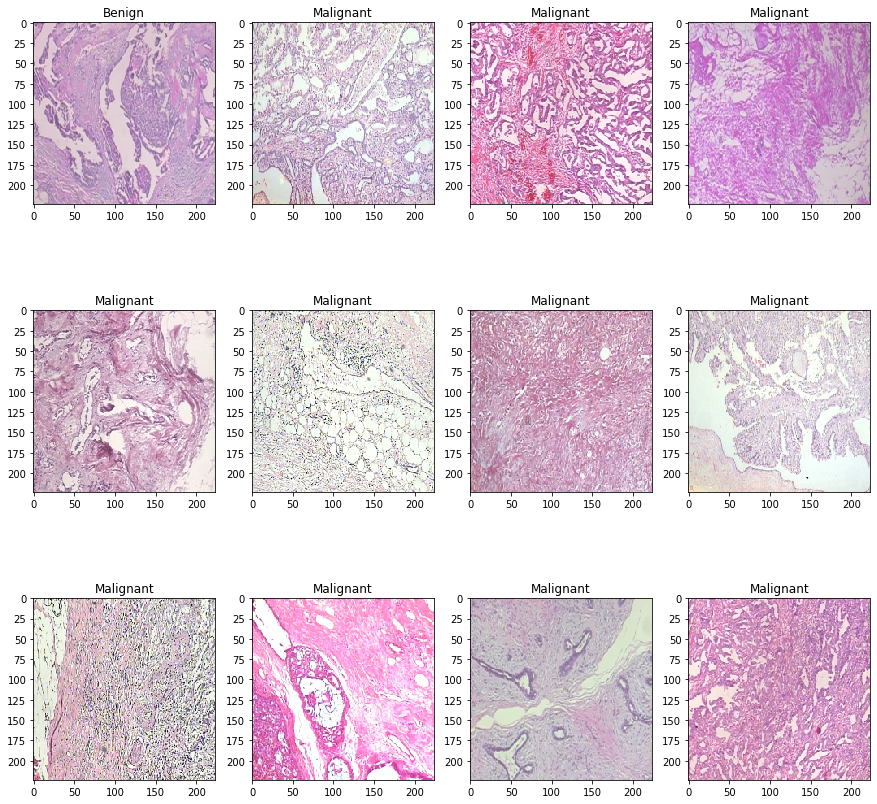

In [35]:

# # Display first 15 images, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

### Image Data Generator

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=[0.5,1.0],  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        brightness_range=[0.2,1.0],
        shear_range=0.2,
)


## ResNet50 model

In [22]:
#define a model
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [24]:
from keras import backend as K

In [26]:
import gc

In [28]:
from keras.applications import ResNet50

In [30]:
from keras.models import Sequential

In [34]:
K.clear_session()
gc.collect()
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 23,542,786
Non-trainable params: 57,216
_________________________________________________________________


In [39]:
from keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, TensorBoard

In [40]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

## Training and Evaluation

In [42]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/20
17/16 [===============================]- ETA: 0s - loss: 0.3290 - accuracy: 0.87 - ETA: 1:02 - loss: 0.2220 - accuracy: 0.90 - ETA: 1:16 - loss: 0.2039 - accuracy: 0.89 - ETA: 1:19 - loss: 0.2904 - accuracy: 0.87 - ETA: 1:18 - loss: 0.2787 - accuracy: 0.86 - ETA: 1:16 - loss: 0.2662 - accuracy: 0.87 - ETA: 1:11 - loss: 0.2713 - accuracy: 0.88 - ETA: 1:06 - loss: 0.3281 - accuracy: 0.85 - ETA: 59s - loss: 0.3215 - accuracy: 0.8611 - ETA: 51s - loss: 0.3103 - accuracy: 0.862 - ETA: 43s - loss: 0.3544 - accuracy: 0.846 - ETA: 35s - loss: 0.3540 - accuracy: 0.843 - ETA: 26s - loss: 0.3379 - accuracy: 0.846 - ETA: 18s - loss: 0.3309 - accuracy: 0.852 - ETA: 8s - loss: 0.3320 - accuracy: 0.853 - ETA: 0s - loss: 0.3306 - accuracy: 0.85 - ETA: -7s - loss: 0.3153 - accuracy: 0.8599
Epoch 00001: val_accuracy improved from 0.72308 to 0.84615, saving model to weights.best.hdf5
17/16 [===============================] - 148s 9s/step - loss: 0.3153 - accuracy: 0.8599 - val_loss: 0.3755 - v

In [43]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

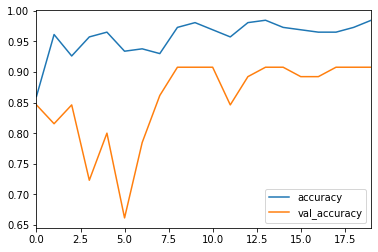

In [44]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

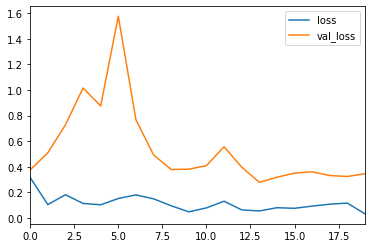

In [45]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()